In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [19]:
#LOAD DEPENDENCIES
import os
import time
import pickle
import logging
import numpy as np
import talos
import tensorflow as tf
import matplotlib.pyplot as plt

#IMPORT LOSS, OPTIMIZER, CALLBACK AND LAYERS
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

#IMPORT MODEL APIs
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as selected_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as student_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as teacher_preprocess

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("LIBRARIES LOADED")

LIBRARIES LOADED


In [20]:
#Tweakable parameters
MODEL_KIND = "KD_model"
MODEL_NAME = "MiniMobileNetV2"

#Models paths
PROPOSED_MODEL_PATH = "models/proposed_model/" + MODEL_NAME
HPO_PATH = "models/hpo_model/" + MODEL_NAME

#Figures paths
FIG_PATH = 'figures/' + MODEL_KIND + "/" + MODEL_NAME

#Data paths
MAIN_DATA_DIR = "ds/"
TRAIN_DATA_DIR = MAIN_DATA_DIR + "train/"
TEST_DATA_DIR = MAIN_DATA_DIR + "test/"
VALIDATION_DATA_DIR = MAIN_DATA_DIR + "val/"

print("ALL REQUERED PATHS SET")

ALL REQUERED PATHS SET


In [21]:
#Save Model Function
def save_m(model, directory, model_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    model.save(directory + "/" + model_name + ".h5")

#Save History Function
def save_h(history, directory, history_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(directory + '/' + history_name + '.history', 'wb') as file:
        pickle.dump(history, file)

#Load model Function
def load_m(directory, model_name):
    if not os.path.exists(directory):
        print("Model File Does Not Exist!!")
        return 
    model = load_model(directory + "/" + model_name + ".h5")
    return model

#Load History Function
def load_h(directory, history_name):
    if not os.path.exists(directory):
        print("History File Does Not Exist!!")
        return 
    with open(directory + '/' + history_name + '.history', 'rb') as file:
        his = pickle.load(file)
    return his

def save_fig(directory, fig_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '/' + fig_name + '.tiff', bbox_inches='tight', dpi=600, format='tiff')
    
print("ALL CUSTOM FUNCTIONS DEFIEND")

ALL CUSTOM FUNCTIONS DEFIEND


In [22]:
#DATA GENERATORS
BATCH_SIZE = 4

img_rows, img_cols = 224, 224
INPUT_SHAPE = (img_rows, img_cols,3)
MODEL_INPUT = Input(shape=INPUT_SHAPE)
print("INPUT SIZE -->", MODEL_INPUT.shape, "\n")
NUM_CLASSES = 199

def create_data_generator(pre_process=None):
    nb_train_samples = 0
    nb_val_samples = 0
    num_classes = 0
    train_generator = None
    validation_generator = None

    train_datagen = ImageDataGenerator(preprocessing_function=pre_process)
    val_datagen = ImageDataGenerator(preprocessing_function=pre_process)

    if not os.path.exists(TRAIN_DATA_DIR):
        print("TRAIN DATA DOES NOT EXITS!")
        return None, None
    else:
        print("LOAD TRAIN SAMPLES...")
        train_generator = train_datagen.flow_from_directory(
                TRAIN_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42)
        
        #CHECK  THE NUMBER OF SAMPLES
        nb_train_samples = len(train_generator.filenames)
        if nb_train_samples == 0:
            print("NO DATA TRAIN FOUND IN TRAIN FOLDER!")
            return None, None

    print()
    if not os.path.exists(TRAIN_DATA_DIR):
        print("VALIDATION DATA DOES NOT EXITS!")
        return None, None
    else:
        print("LOAD VALIDATION SAMPLES...")
        validation_generator = val_datagen.flow_from_directory(
                VALIDATION_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42,
                shuffle=False)

        #CHECK  THE NUMBER OF SAMPLES
        nb_validation_samples = len(validation_generator.filenames)
        if nb_validation_samples == 0:
            print("NO DATA VALIDATION FOUND IN VALIDATION FOLDER!")
            return None, None

    print()
    if nb_train_samples > 0 and nb_validation_samples > 0:
        num_classes= len(train_generator.class_indices)
        print("GENERATER ARE SET!")
        print('CLASSES TO TRAIN', num_classes, 'classes')
    
    return (train_generator, nb_train_samples), (validation_generator, nb_validation_samples)

_, _=create_data_generator()

INPUT SIZE --> (None, 224, 224, 3) 

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes


In [23]:
#Knowledge Distiller(KD)

class KDistiller(Model):
    def __init__(self, student, teacher, student_preprocess=None, teacher_preprocess=None):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.student_preprocess = student_preprocess
        self.teacher_preprocess = teacher_preprocess

    def compile(self, optimizer,  metrics, student_loss_fn, distillation_loss_fn, alpha, temperature):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # UNPACK DATA
        student_x, y = data
        teacher_x, y = data

        # PREPROCESS DATA
        if self.student_preprocess != None: student_x = self.student_preprocess(student_x)
        if self.teacher_preprocess != None: teacher_x = self.teacher_preprocess(teacher_x)
        
        # FORWARD PASS OF TEACHER
        teacher_preds = self.teacher(teacher_x, training=False)

        with tf.GradientTape() as tape:
            # FORWARD PASS OF STUDENT
            student_preds = self.student(student_x, training=True)

            # CALCULATE STUDENT LOSS
            student_loss = self.student_loss_fn(y, student_preds)

            # CALCULATE DISTISLATION LOSS
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )

            # CALCULATE TOTAL LOSS
            total_loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # CALCULATE GRADIENT
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # SET WEIGHTS
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # SET METRICES
        self.compiled_metrics.update_state(y, student_preds)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'loss':total_loss}
        )

        return results

    def test_step(self, data):
        # UNPACK DATA
        x, y = data

        # PREPROCESS DATA
        x = self.student_preprocess(x)
        
        # GET PREDICTIONS FROM STUDENT
        y_preds = self.student(x, training=False)

        # CALCULATE STUDENT LOSS
        student_loss = self.student_loss_fn(y, y_preds)

        # SET METRICES 
        self.compiled_metrics.update_state(y, y_preds)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})

        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model :** EnsembleModel 

In [24]:
TEACHER_NAME = "EfficientNetB7"
TEACHER_MODEL_PATH = "models/teacher_model/" + TEACHER_NAME

In [ ]:
#PLOT THE MODEL STRUCTURE
def get_teacher():
    model = load_m(TEACHER_MODEL_PATH, TEACHER_NAME)
    model.layers[-1].activation = None
    if model != None:
        print("TEACHER MODEL LOADED SUCCESSFULLY!")

    return model

if get_teacher() != None: 
    print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
    get_teacher().summary()

TEACHER MODEL LOADED SUCCESSFULLY!
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
TEACHER MODEL LOADED SUCCESSFULLY!
Model: "benchmark-onelayeroff-0_0001-EfficientNetB7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 22

In [ ]:
#Sanity Checker
#Re-Create Data Generator
_, (validation_generator, nb_validation_samples)  = create_data_generator(pre_process=teacher_preprocess)

get_teacher().evaluate(validation_generator)

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
TEACHER MODEL LOADED SUCCESSFULLY!
299/299 [==============================] - 24s 56ms/step - loss: 15.4561 - accuracy: 0.9054


[15.456077575683594, 0.9053601622581482]

**Student Model :** Mini-MNV2

In [ ]:
#TRANSFER LEARNING
def get_student(model_input):
    model = load_m(PROPOSED_MODEL_PATH, MODEL_NAME)
    model.layers[-1].activation = None
    if model != None:
        print("STUDENT MODEL SUCESSFULLY BUILT!")
    return model

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
get_student(MODEL_INPUT).summary()

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
STUDENT MODEL SUCESSFULLY BUILT!
Model: "ablation_final-PROPOSEDMiniMobileNetV2-39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0] 

In [25]:
#FIXED HYPERPARAMETERS
BATCH_SIZE = 4
EPOCHS = 30
DROPOUT_RATE = 0.5
OPTIMIZER = Adam

#HPO HYPERPAMETERS
TEMPERATURE = [5, 2, 10] 
ALPHA = [0.1, 0.3, 0.5]
LEARNING_RATE = [0.001, 0.01, 0.0001]

print("FIXED HYPERPARAMETERS")
print("---------------------")

print("BATCH_SIZE -->", BATCH_SIZE)
print("EPOCHS SET -->", EPOCHS)
print("DROPOUT_RATE -->", DROPOUT_RATE)
print("OPTIMIZER -->", OPTIMIZER.__name__,"\n")

print("HPO HYPERPARAMETERS")
print("--------------------")
print("TEMPERATURE -->", TEMPERATURE)
print("ALPHA -->", ALPHA)
print("LEARNING_RATE -->", LEARNING_RATE)

FIXED HYPERPARAMETERS
---------------------
BATCH_SIZE --> 4
EPOCHS SET --> 30
DROPOUT_RATE --> 0.5
OPTIMIZER --> Adam 

HPO HYPERPARAMETERS
--------------------
TEMPERATURE --> [5, 2, 10]
ALPHA --> [0.1, 0.3, 0.5]
LEARNING_RATE --> [0.001, 0.01, 0.0001]


**Training Student With KD**

In [ ]:
dummy_x = []
dummy_y = []

# HPO PARAMETERS
p = {
    'temperature':TEMPERATURE,
    'alpha':ALPHA,
    'lr':LEARNING_RATE
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    print("\nCURRENT PARAMETERS:", params)

    #START TIMER
    import time
    start_time = time.time()
    
    #GET NEW TEACHER AND STUDENT MODEL
    teacher = get_teacher()
    student = get_student(MODEL_INPUT)

    #SET CALLBACK
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.000001)

    callbacks = [reduce_lr]

    #CREATE KNOWLEDGE DISTILLER
    distiller = KDistiller(
        student=student,teacher=teacher,
        student_preprocess=student_preprocess,
        teacher_preprocess=teacher_preprocess
    )

    #COMPILE KNOWLEDGE DISTILLER
    distiller.compile(
        optimizer = OPTIMIZER(learning_rate=params['lr']),
        metrics=['accuracy'],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    print()
    (train_generator, nb_train_samples), (validation_generator, nb_validation_samples) = create_data_generator()

    #DISTILLING
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples // BATCH_SIZE,
                                        validation_steps = nb_validation_samples // BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=callbacks, 
                                      )
    #STOP TIMER
    elapsed_time = time.time() - start_time
    train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print('\n\n' + train_time, 'train_time\n')
    print(elapsed_time, 'Seconds\n\n')

    print("MODEL SERIALIZING WAIT FOR A MOMENT...\n")
    save_m(distiller.student, HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(params['temperature'],params['alpha'],params['lr']), MODEL_NAME)
    save_h(distiller_history.history, HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(params['temperature'],params['alpha'],params['lr']), MODEL_NAME)

    return distiller_history, distiller.student

scan_object = talos.Scan(dummy_x, dummy_y,
                         x_val=dummy_x, y_val=dummy_y, 
                         model=distiller_model,
                         experiment_name='logs/',
                         params=p,
                         print_params=False,
                         save_weights=True)

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 55s 97ms/step - accuracy: 0.0534 - student_loss: 4.8583 - distillation_loss: 0.3580 - loss: 0.8080 - val_accuracy: 0.0050 - val_student_loss: 44.9399
Epoch 2/30
497/497 [==============================] - 46s 92ms/step - accuracy: 0.1858 - student_loss: 3.5706 - distillation_loss: 0.3203 - loss: 0.6453 - val_accuracy: 0.0352 - val_student_loss: 43.4513
Epoch 3/30
497/497 [==============================] - 46s 92ms/step - accuracy: 0.3827 - student_loss: 2.5954 - distillation_loss: 0.2933 - loss: 0.5235 - val_accuracy: 0.0822 - val_student_loss: 33.8619
Epoch 4/30
497/497 [==============================] - 45s 91ms/st

  4%|██▉                                                                           | 1/27 [23:09<10:02:07, 1389.51s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 52s 93ms/step - accuracy: 0.0287 - student_loss: 5.0462 - distillation_loss: 4.4375 - loss: 4.4984 - val_accuracy: 0.0159 - val_student_loss: 51.6682
Epoch 2/30
497/497 [==============================] - 46s 92ms/step - accuracy: 0.1138 - student_loss: 4.0137 - distillation_loss: 3.6406 - loss: 3.6779 - val_accuracy: 0.0210 - val_student_loss: 76.7497
Epoch 3/30
497/497 [==============================] - 45s 91ms/step - accuracy: 0.2392 - student_loss: 3.1276 - distillation_loss: 2.9281 - loss: 2.9480 - val_accuracy: 0.0092 - val_student_loss: 45.0405
Epoch 4/30
497/497 [==============================] - 46s 93ms/st

  7%|█████▊                                                                         | 2/27 [46:37<9:43:28, 1400.33s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 53s 94ms/step - accuracy: 0.0312 - student_loss: 4.9729 - distillation_loss: 0.0405 - loss: 0.5337 - val_accuracy: 0.0050 - val_student_loss: 27.9840
Epoch 2/30
497/497 [==============================] - 47s 95ms/step - accuracy: 0.1551 - student_loss: 3.8515 - distillation_loss: 0.0393 - loss: 0.4205 - val_accuracy: 0.0126 - val_student_loss: 47.8639
Epoch 3/30
497/497 [==============================] - 47s 95ms/step - accuracy: 0.3157 - student_loss: 2.8124 - distillation_loss: 0.0403 - loss: 0.3175 - val_accuracy: 0.0310 - val_student_loss: 34.3126
Epoch 4/30
497/497 [==============================] - 47s 94ms/s

 11%|████████▌                                                                    | 3/27 [1:10:45<9:28:51, 1422.16s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 55s 97ms/step - accuracy: 0.0116 - student_loss: 5.2307 - distillation_loss: 0.3696 - loss: 0.8557 - val_accuracy: 0.0050 - val_student_loss: 235.0770
Epoch 2/30
497/497 [==============================] - 49s 98ms/step - accuracy: 0.0373 - student_loss: 4.6511 - distillation_loss: 0.3538 - loss: 0.7835 - val_accuracy: 0.0050 - val_student_loss: 224.0062
Epoch 3/30
497/497 [==============================] - 48s 97ms/step - accuracy: 0.0851 - student_loss: 4.1207 - distillation_loss: 0.3432 - loss: 0.7209 - val_accuracy: 0.0050 - val_student_loss: 222.9656

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004

 15%|███████████▍                                                                 | 4/27 [1:35:09<9:11:25, 1438.50s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 55s 98ms/step - accuracy: 0.0101 - student_loss: 5.5149 - distillation_loss: 4.6224 - loss: 4.7116 - val_accuracy: 0.0050 - val_student_loss: 266.9503
Epoch 2/30
497/497 [==============================] - 48s 97ms/step - accuracy: 0.0267 - student_loss: 5.1754 - distillation_loss: 4.2226 - loss: 4.3179 - val_accuracy: 0.0059 - val_student_loss: 134.3954
Epoch 3/30
497/497 [==============================] - 48s 96ms/step - accuracy: 0.0634 - student_loss: 4.7598 - distillation_loss: 3.8074 - loss: 3.9026 - val_accuracy: 0.0050 - val_student_loss: 136.7345
Epoch 4/30
497/497 [==============================] - 49s 98ms/

 19%|██████████████▎                                                              | 5/27 [1:59:28<8:50:14, 1446.13s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 98ms/step - accuracy: 0.0111 - student_loss: 5.3129 - distillation_loss: 0.0417 - loss: 0.5688 - val_accuracy: 0.0050 - val_student_loss: 149.8640
Epoch 2/30
497/497 [==============================] - 47s 94ms/step - accuracy: 0.0307 - student_loss: 4.7831 - distillation_loss: 0.0426 - loss: 0.5166 - val_accuracy: 0.0050 - val_student_loss: 156.1295
Epoch 3/30
497/497 [==============================] - 47s 95ms/step - accuracy: 0.0665 - student_loss: 4.2846 - distillation_loss: 0.0446 - loss: 0.4686 - val_accuracy: 0.0050 - val_student_loss: 235.5710

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00

 22%|█████████████████                                                            | 6/27 [2:23:43<8:27:08, 1448.97s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 100ms/step - accuracy: 0.0171 - student_loss: 5.2504 - distillation_loss: 0.3707 - loss: 0.8586 - val_accuracy: 0.0101 - val_student_loss: 5.3968
Epoch 2/30
497/497 [==============================] - 49s 99ms/step - accuracy: 0.0519 - student_loss: 4.8971 - distillation_loss: 0.3602 - loss: 0.8139 - val_accuracy: 0.0193 - val_student_loss: 5.8534
Epoch 3/30
497/497 [==============================] - 49s 99ms/step - accuracy: 0.0785 - student_loss: 4.5619 - distillation_loss: 0.3498 - loss: 0.7710 - val_accuracy: 0.0512 - val_student_loss: 4.0267
Epoch 4/30
497/497 [==============================] - 49s 99ms/ste

 26%|███████████████████▉                                                         | 7/27 [2:49:00<8:10:23, 1471.17s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 59s 105ms/step - accuracy: 0.0116 - student_loss: 5.2900 - distillation_loss: 4.6385 - loss: 4.7037 - val_accuracy: 0.0101 - val_student_loss: 6.2827
Epoch 2/30
497/497 [==============================] - 52s 105ms/step - accuracy: 0.0468 - student_loss: 4.9210 - distillation_loss: 4.4485 - loss: 4.4958 - val_accuracy: 0.0176 - val_student_loss: 6.2073
Epoch 3/30
497/497 [==============================] - 52s 105ms/step - accuracy: 0.0700 - student_loss: 4.5458 - distillation_loss: 4.2307 - loss: 4.2622 - val_accuracy: 0.0319 - val_student_loss: 5.9486
Epoch 4/30
497/497 [==============================] - 52s 104ms/

 30%|██████████████████████▊                                                      | 8/27 [3:15:10<7:55:50, 1502.66s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 58s 105ms/step - accuracy: 0.0111 - student_loss: 5.2634 - distillation_loss: 0.0411 - loss: 0.5633 - val_accuracy: 0.0134 - val_student_loss: 5.1845
Epoch 2/30
497/497 [==============================] - 53s 106ms/step - accuracy: 0.0433 - student_loss: 4.9145 - distillation_loss: 0.0399 - loss: 0.5274 - val_accuracy: 0.0193 - val_student_loss: 5.2144
Epoch 3/30
497/497 [==============================] - 52s 104ms/step - accuracy: 0.0937 - student_loss: 4.6088 - distillation_loss: 0.0392 - loss: 0.4962 - val_accuracy: 0.0604 - val_student_loss: 4.6370
Epoch 4/30
497/497 [==============================] - 52s 105ms

 33%|█████████████████████████▋                                                   | 9/27 [3:40:36<7:33:02, 1510.12s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 101ms/step - accuracy: 0.0342 - student_loss: 4.9359 - distillation_loss: 0.3607 - loss: 1.7332 - val_accuracy: 0.0143 - val_student_loss: 14.3319
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.1490 - student_loss: 3.7714 - distillation_loss: 0.3270 - loss: 1.3603 - val_accuracy: 0.0327 - val_student_loss: 28.1458
Epoch 3/30
497/497 [==============================] - 50s 100ms/step - accuracy: 0.3374 - student_loss: 2.7269 - distillation_loss: 0.3003 - loss: 1.0283 - val_accuracy: 0.0537 - val_student_loss: 16.0644
Epoch 4/30
497/497 [==============================] - 50s 100m

 37%|████████████████████████████▏                                               | 10/27 [4:05:46<7:07:50, 1510.05s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 101ms/step - accuracy: 0.0408 - student_loss: 4.9934 - distillation_loss: 4.4365 - loss: 4.6036 - val_accuracy: 0.0117 - val_student_loss: 31.8037
Epoch 2/30
497/497 [==============================] - 50s 102ms/step - accuracy: 0.1319 - student_loss: 3.8992 - distillation_loss: 3.6659 - loss: 3.7359 - val_accuracy: 0.0101 - val_student_loss: 34.9337
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.2739 - student_loss: 2.9526 - distillation_loss: 2.9524 - loss: 2.9524 - val_accuracy: 0.0143 - val_student_loss: 43.4034
Epoch 4/30
497/497 [==============================] - 50s 101m

 41%|██████████████████████████████▉                                             | 11/27 [4:30:59<6:42:54, 1510.89s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 101ms/step - accuracy: 0.0403 - student_loss: 4.9756 - distillation_loss: 0.0406 - loss: 1.5211 - val_accuracy: 0.0159 - val_student_loss: 34.0605
Epoch 2/30
497/497 [==============================] - 50s 100ms/step - accuracy: 0.1349 - student_loss: 3.8195 - distillation_loss: 0.0399 - loss: 1.1738 - val_accuracy: 0.0134 - val_student_loss: 44.6209
Epoch 3/30
497/497 [==============================] - 50s 100ms/step - accuracy: 0.3087 - student_loss: 2.8410 - distillation_loss: 0.0415 - loss: 0.8814 - val_accuracy: 0.0126 - val_student_loss: 35.2633

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0

 44%|█████████████████████████████████▊                                          | 12/27 [4:56:09<6:17:39, 1510.64s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 101ms/step - accuracy: 0.0121 - student_loss: 5.3249 - distillation_loss: 0.3730 - loss: 1.8586 - val_accuracy: 0.0050 - val_student_loss: 110.2013
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0358 - student_loss: 4.7674 - distillation_loss: 0.3590 - loss: 1.6815 - val_accuracy: 0.0050 - val_student_loss: 137.7155
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0806 - student_loss: 4.2278 - distillation_loss: 0.3512 - loss: 1.5142 - val_accuracy: 0.0050 - val_student_loss: 89.1716

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0

 48%|████████████████████████████████████▌                                       | 13/27 [5:21:31<5:53:18, 1514.19s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 101ms/step - accuracy: 0.0111 - student_loss: 5.4791 - distillation_loss: 4.6658 - loss: 4.9098 - val_accuracy: 0.0050 - val_student_loss: 247.2189
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0312 - student_loss: 5.0097 - distillation_loss: 4.2527 - loss: 4.4798 - val_accuracy: 0.0050 - val_student_loss: 128.6740
Epoch 3/30
497/497 [==============================] - 50s 100ms/step - accuracy: 0.0670 - student_loss: 4.5716 - distillation_loss: 3.8630 - loss: 4.0756 - val_accuracy: 0.0050 - val_student_loss: 167.4587

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

 52%|███████████████████████████████████████▍                                    | 14/27 [5:46:50<5:28:21, 1515.51s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 102ms/step - accuracy: 0.0176 - student_loss: 5.3020 - distillation_loss: 0.0419 - loss: 1.6200 - val_accuracy: 0.0050 - val_student_loss: 168.5627
Epoch 2/30
497/497 [==============================] - 50s 100ms/step - accuracy: 0.0342 - student_loss: 4.8216 - distillation_loss: 0.0432 - loss: 1.4767 - val_accuracy: 0.0050 - val_student_loss: 177.3052
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0650 - student_loss: 4.3709 - distillation_loss: 0.0460 - loss: 1.3435 - val_accuracy: 0.0050 - val_student_loss: 102.0014

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0

 56%|██████████████████████████████████████████▏                                 | 15/27 [6:11:35<5:01:16, 1506.35s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 102ms/step - accuracy: 0.0070 - student_loss: 5.2839 - distillation_loss: 0.3718 - loss: 1.8455 - val_accuracy: 0.0059 - val_student_loss: 5.2168
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0504 - student_loss: 4.9157 - distillation_loss: 0.3610 - loss: 1.7274 - val_accuracy: 0.0327 - val_student_loss: 3.7949
Epoch 3/30
497/497 [==============================] - 51s 103ms/step - accuracy: 0.0901 - student_loss: 4.5548 - distillation_loss: 0.3508 - loss: 1.6120 - val_accuracy: 0.0143 - val_student_loss: 3.5971
Epoch 4/30
497/497 [==============================] - 50s 100ms/

 59%|█████████████████████████████████████████████                               | 16/27 [6:36:53<4:36:49, 1509.96s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 103ms/step - accuracy: 0.0146 - student_loss: 5.2823 - distillation_loss: 4.6363 - loss: 4.8301 - val_accuracy: 0.0101 - val_student_loss: 5.2177
Epoch 2/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0468 - student_loss: 4.9022 - distillation_loss: 4.4474 - loss: 4.5839 - val_accuracy: 0.0201 - val_student_loss: 6.3818
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0791 - student_loss: 4.5806 - distillation_loss: 4.2614 - loss: 4.3572 - val_accuracy: 0.0361 - val_student_loss: 5.4318
Epoch 4/30
497/497 [==============================] - 50s 101ms/

 63%|███████████████████████████████████████████████▊                            | 17/27 [7:02:19<4:12:26, 1514.66s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 102ms/step - accuracy: 0.0151 - student_loss: 5.2952 - distillation_loss: 0.0411 - loss: 1.6173 - val_accuracy: 0.0109 - val_student_loss: 4.5375
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0438 - student_loss: 4.9297 - distillation_loss: 0.0399 - loss: 1.5068 - val_accuracy: 0.0210 - val_student_loss: 4.0621
Epoch 3/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0861 - student_loss: 4.5937 - distillation_loss: 0.0394 - loss: 1.4057 - val_accuracy: 0.0159 - val_student_loss: 3.4188
Epoch 4/30
497/497 [==============================] - 51s 102ms

 67%|██████████████████████████████████████████████████▋                         | 18/27 [7:27:44<3:47:39, 1517.76s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 102ms/step - accuracy: 0.0327 - student_loss: 4.9628 - distillation_loss: 0.3617 - loss: 2.6623 - val_accuracy: 0.0227 - val_student_loss: 16.4213
Epoch 2/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.1329 - student_loss: 3.8186 - distillation_loss: 0.3294 - loss: 2.0740 - val_accuracy: 0.0151 - val_student_loss: 32.5788
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.3066 - student_loss: 2.8373 - distillation_loss: 0.3065 - loss: 1.5719 - val_accuracy: 0.0554 - val_student_loss: 30.2287
Epoch 4/30
497/497 [==============================] - 50s 101m

 70%|█████████████████████████████████████████████████████▍                      | 19/27 [7:53:11<3:22:44, 1520.53s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 102ms/step - accuracy: 0.0297 - student_loss: 4.9758 - distillation_loss: 4.4408 - loss: 4.7083 - val_accuracy: 0.0227 - val_student_loss: 40.3527
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.1450 - student_loss: 3.7684 - distillation_loss: 3.6592 - loss: 3.7138 - val_accuracy: 0.0378 - val_student_loss: 33.7060
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.2986 - student_loss: 2.7742 - distillation_loss: 2.9220 - loss: 2.8481 - val_accuracy: 0.0252 - val_student_loss: 42.0472
Epoch 4/30
497/497 [==============================] - 50s 101m

 74%|████████████████████████████████████████████████████████▎                   | 20/27 [8:18:32<2:57:24, 1520.71s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 102ms/step - accuracy: 0.0322 - student_loss: 4.9829 - distillation_loss: 0.0405 - loss: 2.5117 - val_accuracy: 0.0092 - val_student_loss: 35.9857
Epoch 2/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.1490 - student_loss: 3.9094 - distillation_loss: 0.0400 - loss: 1.9747 - val_accuracy: 0.0285 - val_student_loss: 29.0968
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.2951 - student_loss: 2.8566 - distillation_loss: 0.0422 - loss: 1.4494 - val_accuracy: 0.0143 - val_student_loss: 26.4235
Epoch 4/30
497/497 [==============================] - 51s 102

 78%|███████████████████████████████████████████████████████████                 | 21/27 [8:44:00<2:32:17, 1522.86s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 103ms/step - accuracy: 0.0045 - student_loss: 5.4538 - distillation_loss: 0.3764 - loss: 2.9151 - val_accuracy: 0.0059 - val_student_loss: 337.0293
Epoch 2/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0166 - student_loss: 5.1048 - distillation_loss: 0.3680 - loss: 2.7364 - val_accuracy: 0.0050 - val_student_loss: 136.9997
Epoch 3/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0403 - student_loss: 4.6687 - distillation_loss: 0.3617 - loss: 2.5152 - val_accuracy: 0.0050 - val_student_loss: 99.8722

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0

 81%|█████████████████████████████████████████████████████████████▉              | 22/27 [9:09:29<2:07:02, 1524.59s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 101ms/step - accuracy: 0.0166 - student_loss: 5.3822 - distillation_loss: 4.6265 - loss: 5.0043 - val_accuracy: 0.0050 - val_student_loss: 158.0955
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0297 - student_loss: 4.9413 - distillation_loss: 4.2726 - loss: 4.6070 - val_accuracy: 0.0050 - val_student_loss: 146.9702
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0639 - student_loss: 4.5041 - distillation_loss: 3.9112 - loss: 4.2076 - val_accuracy: 0.0050 - val_student_loss: 148.9325

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

 85%|████████████████████████████████████████████████████████████████▋           | 23/27 [9:34:52<1:41:37, 1524.25s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 103ms/step - accuracy: 0.0081 - student_loss: 5.3888 - distillation_loss: 0.0420 - loss: 2.7154 - val_accuracy: 0.0050 - val_student_loss: 260.7854
Epoch 2/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0277 - student_loss: 4.9429 - distillation_loss: 0.0430 - loss: 2.4929 - val_accuracy: 0.0050 - val_student_loss: 230.3529
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0493 - student_loss: 4.5100 - distillation_loss: 0.0456 - loss: 2.2778 - val_accuracy: 0.0067 - val_student_loss: 175.1052
Epoch 4/30
497/497 [==============================] - 50s 1

 89%|██████████████████████████████████████████████████████████████████▋        | 24/27 [10:00:18<1:16:14, 1524.90s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 57s 102ms/step - accuracy: 0.0166 - student_loss: 5.2639 - distillation_loss: 0.3713 - loss: 2.8176 - val_accuracy: 0.0143 - val_student_loss: 4.1794
Epoch 2/30
497/497 [==============================] - 50s 102ms/step - accuracy: 0.0524 - student_loss: 4.8962 - distillation_loss: 0.3605 - loss: 2.6284 - val_accuracy: 0.0084 - val_student_loss: 3.9659
Epoch 3/30
497/497 [==============================] - 51s 102ms/step - accuracy: 0.0906 - student_loss: 4.5830 - distillation_loss: 0.3517 - loss: 2.4673 - val_accuracy: 0.0495 - val_student_loss: 4.4192
Epoch 4/30
497/497 [==============================] - 50s 101ms/

 93%|███████████████████████████████████████████████████████████████████████▎     | 25/27 [10:25:42<50:49, 1524.60s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 56s 102ms/step - accuracy: 0.0171 - student_loss: 5.2694 - distillation_loss: 4.6332 - loss: 4.9513 - val_accuracy: 0.0134 - val_student_loss: 4.5133
Epoch 2/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0463 - student_loss: 4.8880 - distillation_loss: 4.4403 - loss: 4.6642 - val_accuracy: 0.0277 - val_student_loss: 3.7015
Epoch 3/30
497/497 [==============================] - 50s 101ms/step - accuracy: 0.0801 - student_loss: 4.5725 - distillation_loss: 4.2667 - loss: 4.4196 - val_accuracy: 0.0336 - val_student_loss: 3.7453
Epoch 4/30
497/497 [==============================] - 50s 101ms/

 96%|██████████████████████████████████████████████████████████████████████████▏  | 26/27 [10:51:15<25:27, 1527.14s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 61s 110ms/step - accuracy: 0.0131 - student_loss: 5.2748 - distillation_loss: 0.0411 - loss: 2.6580 - val_accuracy: 0.0134 - val_student_loss: 4.3775
Epoch 2/30
497/497 [==============================] - 55s 110ms/step - accuracy: 0.0514 - student_loss: 4.9254 - distillation_loss: 0.0399 - loss: 2.4827 - val_accuracy: 0.0201 - val_student_loss: 4.2174
Epoch 3/30
497/497 [==============================] - 54s 108ms/step - accuracy: 0.0856 - student_loss: 4.5858 - distillation_loss: 0.0393 - loss: 2.3126 - val_accuracy: 0.0529 - val_student_loss: 4.3537
Epoch 4/30
497/497 [==============================] - 50s 101ms

100%|█████████████████████████████████████████████████████████████████████████████| 27/27 [11:16:50<00:00, 1504.10s/it]


**Select Best Student**

In [26]:
#Re-Create Data Generator
_, (validation_generator, nb_validation_samples)  = create_data_generator(pre_process=student_preprocess)

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes


In [15]:
#Select the model with highest validation accuracy
def ChooseBest():
    best_model = 0
    best_temp = 0
    best_alpha = 0
    best_lr = 0
    max_val_acc = 0

    for a in ALPHA:
        for t in TEMPERATURE:
          for l in LEARNING_RATE:
              print("\nFor Temperature = {0} & alpha= {1} & lr={2}".format(t,a,l))
              #load trained model with temp t and alpha a
              model_path = HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(t,a,l)
              student_model = load_m(model_path, MODEL_NAME)
              student_model.compile(metrics=['accuracy'], loss=CategoricalCrossentropy(from_logits=True))
              #validate model
              val_acc = student_model.evaluate(validation_generator)[1]

              #update best parameters
              if val_acc > max_val_acc:
                  max_val_acc = val_acc
                  best_model = student_model
                  best_alpha = a
                  best_temp = t
                  best_lr = l
                
    return best_alpha, best_temp, best_lr, best_model

best_alpha, best_temp, best_lr, best_model = ChooseBest()

print('\nBest Temperature:', best_temp)
print('Best Alpha:', best_alpha)
print('Best Learning Rate:', best_lr)


For Temperature = 5 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 610s 2s/step - loss: 0.3667 - accuracy: 0.8928

For Temperature = 5 & alpha= 0.1 & lr=0.01
299/299 [==============================] - 43s 138ms/step - loss: 0.6484 - accuracy: 0.8258

For Temperature = 5 & alpha= 0.1 & lr=0.0001
299/299 [==============================] - 42s 136ms/step - loss: 1.1775 - accuracy: 0.7228

For Temperature = 2 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 42s 138ms/step - loss: 0.5775 - accuracy: 0.8635

For Temperature = 2 & alpha= 0.1 & lr=0.01
299/299 [==============================] - 43s 139ms/step - loss: 1.4883 - accuracy: 0.7010

For Temperature = 2 & alpha= 0.1 & lr=0.0001
299/299 [==============================] - 42s 138ms/step - loss: 1.5397 - accuracy: 0.6072

For Temperature = 10 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 43s 139ms/step - loss: 0.3709 - accuracy: 0.8936

For Temperature = 10 & alpha= 0.1 & lr=0.

**Evaluating best student model on Validation and Test**

In [27]:
#LOAD TEST DATA
test_datagen = ImageDataGenerator(preprocessing_function=student_preprocess)

if not os.path.exists(TEST_DATA_DIR):
    print("TEST DATA DOES NOT EXITS!")
else:
    print("LOAD TEST SAMPLES...")
    test_generator = test_datagen.flow_from_directory(
                TEST_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42,
                shuffle=False)

    #CHECK  THE NUMBER OF SAMPLES
    nb_test_samples = len(test_generator.filenames)
    if nb_test_samples == 0:
        print("NO DATA TEST FOUND IN TEST FOLDER!")

LOAD TEST SAMPLES...
Found 796 images belonging to 199 classes.


In [37]:
#Evaluate Best Student model against Teacher model on test set
print("Evaluating Best Student on validation dataset")
best_model.evaluate(validation_generator)

print("\nEvaluating Best Student on test dataset")
best_model.evaluate(test_generator)

Evaluating Best Student on validation dataset
299/299 [==============================] - 43s 138ms/step - loss: 0.3358 - accuracy: 0.9079

Evaluating Best Student on test dataset
199/199 [==============================] - 426s 2s/step - loss: 0.3420 - accuracy: 0.9095


[0.34196093678474426, 0.909547746181488]

**Saving Model**

In [40]:
import shutil

des = PROPOSED_MODEL_PATH + '-KD'

#save models
shutil.copytree(HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(best_temp,best_alpha,best_lr), des)

print("[INFO] BEST STUDENT MODEL AND HISTORY SAVED")

[INFO] BEST STUDENT MODEL AND HISTORY SAVED


In [41]:
#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

history = load_h(PROPOSED_MODEL_PATH + '-KD', MODEL_NAME)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

<Figure size 7200x7200 with 0 Axes>

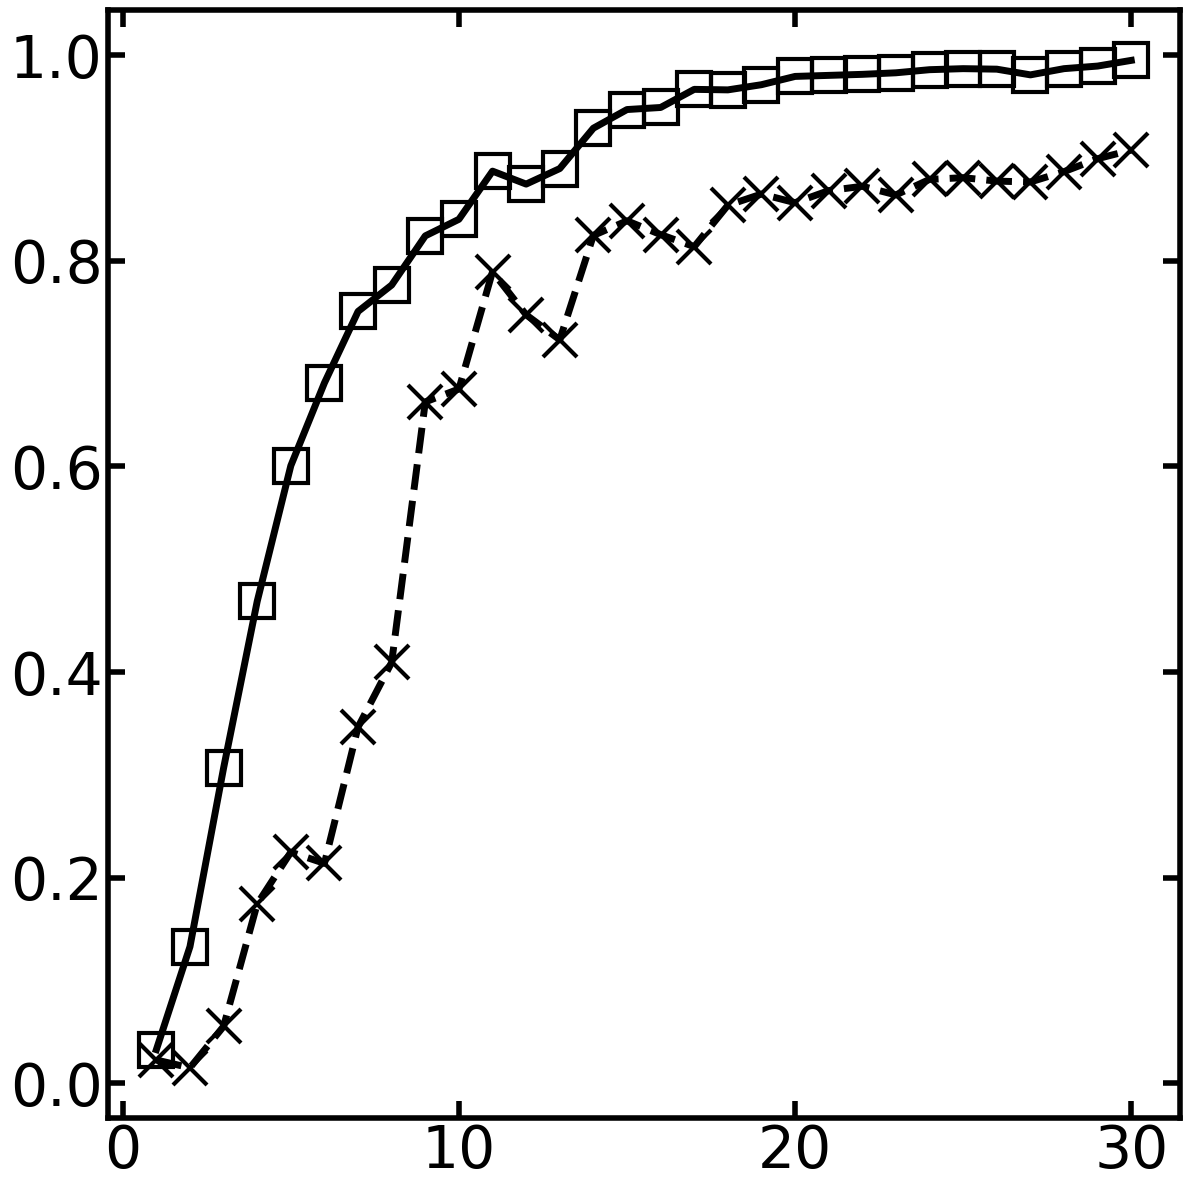

In [43]:
#Accuracy and Loss Graph
epochs = EPOCHS

plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = 600, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)
plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.tight_layout()
save_fig(FIG_PATH, MODEL_NAME + '-AccuracyGraph')

<Figure size 7200x7200 with 0 Axes>

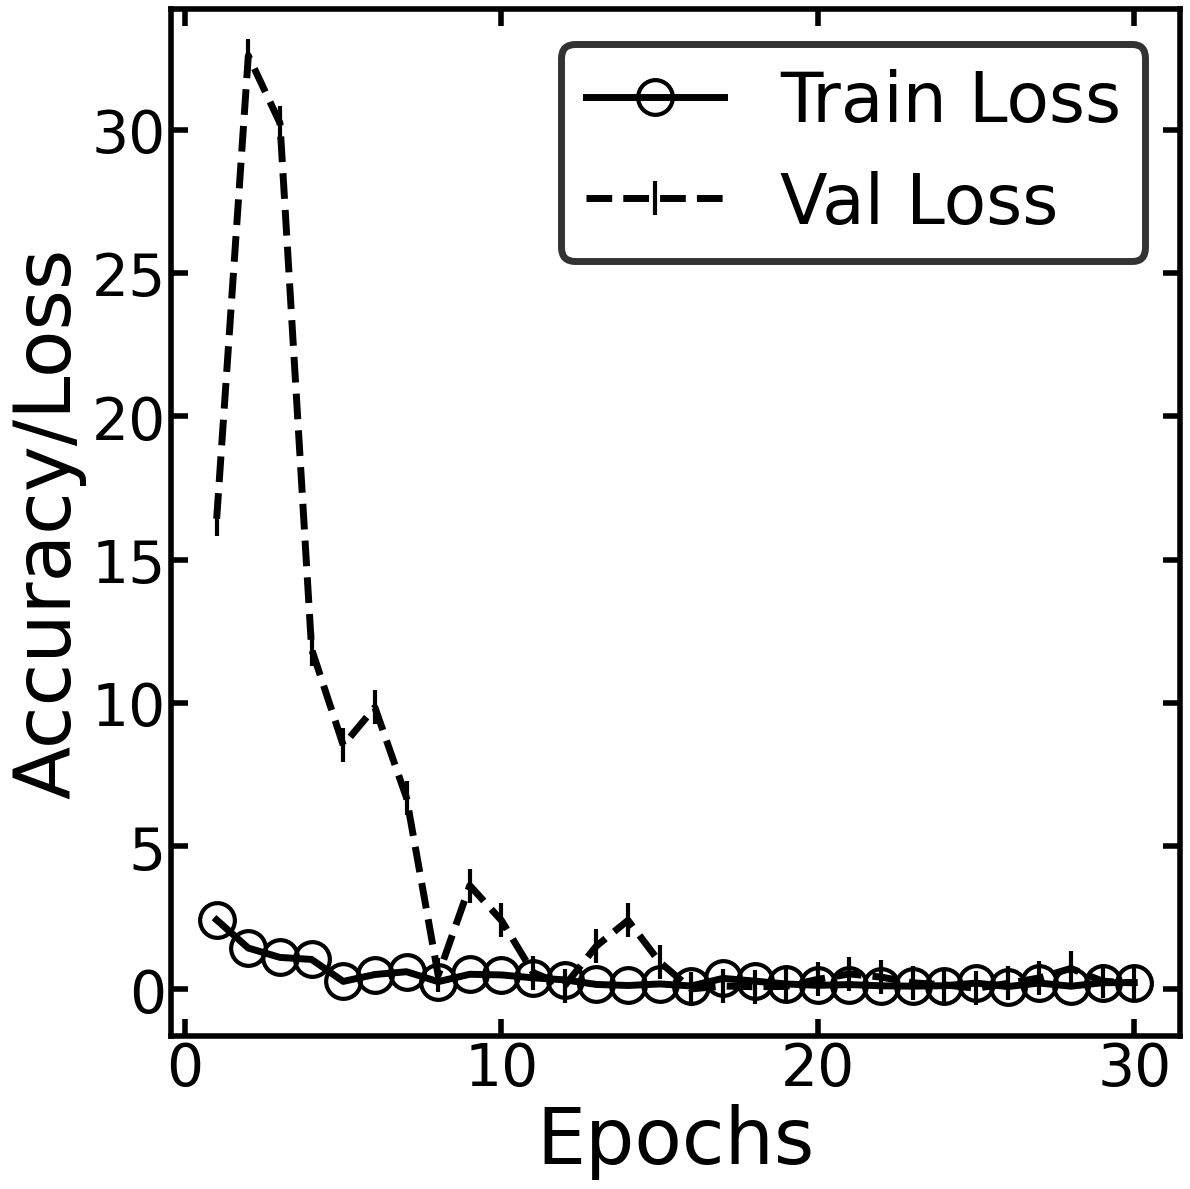

In [44]:
#Accuracy and Loss Graph
epochs = EPOCHS

plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = 600, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)
plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history["val_student_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)

plt.tight_layout()
save_fig(FIG_PATH, MODEL_NAME + '-LossGraph')